In [189]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.api as sms
from math import ceil
import scipy.stats as stats
from scipy.stats import binom

In [190]:
# Reading in data
df = pd.read_csv('https://github.com/erood/interviewqs.com_code_snippets/blob/master/Datasets/ab_data.csv?raw=true', parse_dates=True) 
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [191]:
#The control group should always align with the old landing page, 
#and treatment group should always align with the new landing page. 
print(pd.crosstab(df['group'], df['landing_page']))
v1= len(df[(df['landing_page']=='old_page') & (df['group']=='treatment')])
v2= len(df[(df['landing_page']=='new_page') & (df['group']=='control')])
print(f"\nThere are {v1} misaligned treatment group data units and {v2} control group units")



landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965

There are 1965 misaligned treatment group data units and 1928 control group units


In [192]:
#If these do not line up - we drop the rows

print(f"We are going to drop {v1+v2} data units")

df=df.loc[~((df['landing_page']=='new_page') & (df['group']=='control'))]
df=df.loc[~((df['landing_page']=='old_page') & (df['group']=='treatment'))]

v1= len(df[(df['landing_page']=='old_page') & (df['group']=='treatment')])
v2= len(df[(df['landing_page']=='new_page') & (df['group']=='control')])
print(f"There are now {v1} misaligned treatment group data units and {v2} control group units")

t1= len(df[(df['landing_page']=='new_page') & (df['group']=='treatment')])
c1= len(df[(df['landing_page']=='old_page') & (df['group']=='control')])
print(f"There are now {t1} subjects in treatment group and {c1} subjects in control group")

We are going to drop 3893 data units
There are now 0 misaligned treatment group data units and 0 control group units
There are now 145311 subjects in treatment group and 145274 subjects in control group


In [193]:
# Now we need to verify that no users has been recorded more than once:
doubles_df=df['user_id'].value_counts(ascending=False)
print(f"There are {len(doubles_df[doubles_df>1])} dublicates in the dataset")
# As the number is not significant compare to the full dataset length, we are going to drop dublicates:
df=df.drop_duplicates(subset=['user_id'])

There are 1 dublicates in the dataset


In [194]:
print(pd.crosstab(df['group'], df['landing_page']))

landing_page  new_page  old_page
group                           
control              0    145274
treatment       145310         0


## Formulating a Hypothesis: 

<i>This will make sure our interpretation of the results is correct as well as rigorous.</i>

The new page design has a higher conversion rate (the user is going through with the purchase).
The assumption: we want to know if the new page "converts" more users: one-tailed hypothesis test.

Hₒ: p = pₒ (same)
Hₐ: p > pₒ (performs better)

Confidence level of 95%: α = 0.05

Independent variable: group
Dependent variable: conversion

Test metrics: z-test, power analysis to predict the error probability.

In [195]:
H0 = "The new design doesn't determine success in the probability of users going with the sign-up."
Ha = "The new design determines success in the probability of users going with the sign-up."
alpha = 0.05


Calculating acceptable sample size for testing:
* base conversion rate is assumed 0.1 (10%)
* effect size is assumed 0.02 (2% increase)
* power test set to 0.8 by convention
* significance level (α) = 0.05 as set up earlier

In [196]:
# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.10, 0.12)    
# Calculating sample size needed
sample_size = ceil(sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=alpha, 
    ratio=1
    )                                               
    )   
                    
print(sample_size)

3835


In [197]:
#Calculate conversion rates of both groups from population
ab_summary = df.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = df.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = df.pivot_table(values='converted', index='group')
print(ab_summary)
print(f"\nDifference between rates is {ab_summary['rate'][0]-ab_summary['rate'][1]:.4f}")

           converted   total      rate
group                                 
control        17489  145274  0.120386
treatment      17264  145310  0.118808

Difference between rates is 0.0016


In [198]:
#Calculate conversion rates of both groups from random sample of 3835
control_sample = df[df['group'] == 'control'].sample(n=sample_size, random_state=10)
treatment_sample = df[df['group'] == 'treatment'].sample(n=sample_size, random_state=10)

df_sample = pd.concat([control_sample, treatment_sample], axis=0)
df_sample.reset_index(drop=True, inplace=True)

ab_rand_summary = df_sample.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_rand_summary['total'] = df_sample.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_rand_summary['rate'] = df_sample.pivot_table(values='converted', index='group')
print(ab_rand_summary)
print(f"\nDifference between rates is {ab_rand_summary['rate'][0]-ab_summary['rate'][1]:.4f}")

           converted  total      rate
group                                
control          415   3835  0.108214
treatment        473   3835  0.123338

Difference between rates is -0.0106


Observational Note:
The conversion rates are very similar with treatment rate being lower than the control group.
The toal count of conversions is higher for the treatment group.
However, it is worth running the hypothesis test to verify the effectivness of the second page vs the old one.

In [199]:
#calculating basic statistics:
mean_c=df_sample[df_sample['group']=='control']['converted'].mean()
std_c=df_sample[df_sample['group']=='control']['converted'].std()
count_c=df_sample[df_sample['group']=='control']['converted'].count()
conv_c=df_sample[df_sample['group']=='control']['converted'].sum()

mean_t=df_sample[df_sample['group']=='treatment']['converted'].mean()
std_t=df_sample[df_sample['group']=='treatment']['converted'].std()
count_t=df_sample[df_sample['group']=='treatment']['converted'].count()
conv_t=df_sample[df_sample['group']=='treatment']['converted'].sum()

#Z test: calculate expected frequencies & Z-scores
from  scipy.stats import zscore
df_sample=df_sample.iloc[:, 2:5]
df_sample['z_score'] = df_sample.groupby('group')['converted'].transform(lambda x: zscore(x, ddof=1))

print("mean A & B:   ", round(mean_c,5), "  ", round(mean_t, 5))
print("st dev A & B: ", round(std_c,5), "  ", round(std_t,5))
print("total A & B:  ", count_c, "     ", count_t)
print("converted A & B:", conv_c, "     ", conv_t)
print(df_sample.head(5))

mean A & B:    0.10821    0.12334
st dev A & B:  0.31069    0.32887
total A & B:   3835       3835
converted A & B: 415       473
     group landing_page  converted   z_score
0  control     old_page          0 -0.348301
1  control     old_page          0 -0.348301
2  control     old_page          0 -0.348301
3  control     old_page          0 -0.348301
4  control     old_page          0 -0.348301


Text(0, 0.5, 'probability')

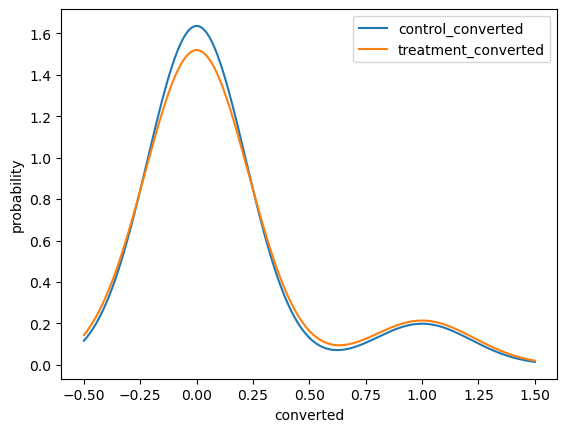

In [219]:
#Let's visualise the distribution of both groups:
control_converted=df_sample[df_sample['group']=='control']['converted']
treatment_converted=df_sample[df_sample['group']=='treatment']['converted'].reset_index(drop=True)
df_plot = pd.DataFrame({
    'control_converted': control_converted,
    'treatment_converted': treatment_converted 
    })
df_plot
ax = df_plot.plot.kde(bw_method=0.7)
plt.xlabel('converted')
plt.ylabel('probability')

In [1]:
from bioinfokit.analys import stat
res=stat()
res.ztest(df=df_plot, x='control_converted', y='treatment_converted', x_std=std_c, y_std=std_t, test_type=2)
print(res.summary)

ModuleNotFoundError: No module named 'matplotlib_venn'

Summary:

According to the p-value of the Z-stat test, the Ho hypothesis should not be rejected.
The new_page alternative is not effective enough to alter the conversion rate.
